In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import pearsonr

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Explore the data directory for RMSD files
print("Scanning ../data/ for RMSD files...")
data_dir = '/home/matargyl/groups/fslg_dellacortelab/nobackup/autodelete/rmsf_at_home/final_data'
rmsd_files = []

for file in os.listdir(data_dir):
    if file.endswith('_rmsd.txt') or (file.endswith('.xvg') and 'rmsd' in file.lower()):
        rmsd_files.append(file)
        print(f"Found: {file}")

print(f"\nTotal RMSD files found: {len(rmsd_files)}")
rmsd_files.sort()
print("Sorted file list:", rmsd_files)

Scanning ../data/ for RMSD files...
Found: ak_af_rmsd.txt
Found: ak_md_run1_final_rmsd.xvg
Found: ak_md_run2_final_rmsd.xvg
Found: ak_md_run3_final_rmsd.xvg
Found: hiv_af_rmsd.txt
Found: hiv_md_run1_final_rmsd.xvg
Found: hiv_md_run2_final_rmsd.xvg
Found: hiv_md_run3_final_rmsd.xvg
Found: lipa_af_rmsd.txt
Found: lipa_md_run1_final_rmsd.xvg
Found: lipa_md_run2_final_rmsd.xvg
Found: lipa_md_run3_final_rmsd.xvg
Found: onc_af_rmsd.txt
Found: onc_md_run1_final_rmsd.xvg
Found: onc_md_run2_final_rmsd.xvg
Found: onc_md_run3_final_rmsd.xvg

Total RMSD files found: 16
Sorted file list: ['ak_af_rmsd.txt', 'ak_md_run1_final_rmsd.xvg', 'ak_md_run2_final_rmsd.xvg', 'ak_md_run3_final_rmsd.xvg', 'hiv_af_rmsd.txt', 'hiv_md_run1_final_rmsd.xvg', 'hiv_md_run2_final_rmsd.xvg', 'hiv_md_run3_final_rmsd.xvg', 'lipa_af_rmsd.txt', 'lipa_md_run1_final_rmsd.xvg', 'lipa_md_run2_final_rmsd.xvg', 'lipa_md_run3_final_rmsd.xvg', 'onc_af_rmsd.txt', 'onc_md_run1_final_rmsd.xvg', 'onc_md_run2_final_rmsd.xvg', 'onc_md_run

In [13]:
# Load and organize RMSD data by protein target
def load_rmsd_file(filepath):
    """Load RMSD data from file, handling Gromacs XVG and other formats"""
    try:
        if filepath.endswith('.xvg'):
            # Handle Gromacs XVG files (skip comment and header lines)
            data = []
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    # Skip comments and headers
                    if line.startswith('#') or line.startswith('@') or not line:
                        continue
                    # Parse data lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            time_val = float(parts[0])  # Time in ps
                            rmsd_val = float(parts[1])  # RMSD in nm (convert to Angstrom)
                            data.append([time_val, rmsd_val * 10])  # Convert nm to Angstrom
                        except ValueError:
                            continue
            
            if data:
                data = np.array(data)
                return data[:, 0], data[:, 1]  # time, rmsd
            else:
                print(f"No valid data found in {filepath}")
                return None, None
        
        else:
            # Handle regular text files
            try:
                # Try loading with pandas first
                data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')
                if data.shape[1] >= 2:
                    return data.iloc[:, 0].values, data.iloc[:, 1].values  # time, rmsd
                else:
                    # If only one column, assume it's RMSD and create time points
                    rmsd_values = data.iloc[:, 0].values * 10. #to convert from nm to Angstrom
                    time_values = np.linspace(0, 250, len(rmsd_values))
                    return time_values, rmsd_values
            except:
                # Fallback to numpy
                data = np.loadtxt(filepath)
                if data.ndim == 2 and data.shape[1] >= 2:
                    return data[:, 0], data[:, 1]
                else:
                    return np.arange(len(data)), data
    
    except Exception as e:
        print(f"Could not load {filepath}: {e}")
        return None, None

# Organize data by protein target
protein_data = {
    'AK': {'af3': None, 'md_runs': []},
    'HIV': {'af3': None, 'md_runs': []},
    'LipA': {'af3': None, 'md_runs': []},
    'Onconase': {'af3': None, 'md_runs': []}
}

# Load all RMSD files
print("Loading RMSD files...")
for file in rmsd_files:
    filepath = os.path.join(data_dir, file)
    time_vals, rmsd_vals = load_rmsd_file(filepath)
    
    if time_vals is not None and rmsd_vals is not None:
        print(f"Loaded {file}: {len(rmsd_vals)} data points")
        
        # Classify by protein target and type
        file_lower = file.lower()
        
        # Determine protein target
        if 'ak' in file_lower:
            target = 'AK'
        elif 'hiv' in file_lower:
            target = 'HIV'
        elif 'lipa' in file_lower or 'lipase' in file_lower:
            target = 'LipA'
        elif 'onc' in file_lower:
            target = 'Onconase'
        else:
            print(f"Unknown protein target in file: {file}")
            continue
        
        # Determine data type (AF3 vs MD)
        if 'af' in file_lower:
            protein_data[target]['af3'] = (time_vals, rmsd_vals, file)
        elif ('md' in file_lower) or ('rmsd1' in file_lower) or ('rmsd2' in file_lower) or ('rmsd3' in file_lower):
            protein_data[target]['md_runs'].append((time_vals, rmsd_vals, file))
        else:
            print(f"Could not classify file type: {file}")

# Print summary of loaded data
print("\nData summary:")
for protein, data in protein_data.items():
    af3_status = "✓" if data['af3'] is not None else "✗"
    md_count = len(data['md_runs'])
    print(f"{protein}: AF3 {af3_status}, MD runs: {md_count}")
    if data['af3']:
        print(f"  AF3: {data['af3'][2]}")

    for i, (_, _, filename) in enumerate(data['md_runs']):
        print(f"  MD{i+1}: {filename}")

Loading RMSD files...
Loaded ak_af_rmsd.txt: 101 data points


<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_412041/1306662687.py:35: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')


Loaded ak_md_run1_final_rmsd.xvg: 25001 data points
Loaded ak_md_run2_final_rmsd.xvg: 25001 data points
Loaded ak_md_run3_final_rmsd.xvg: 25001 data points
Loaded hiv_af_rmsd.txt: 101 data points
Loaded hiv_md_run1_final_rmsd.xvg: 25001 data points
Loaded hiv_md_run2_final_rmsd.xvg: 25001 data points
Loaded hiv_md_run3_final_rmsd.xvg: 25001 data points
Loaded lipa_af_rmsd.txt: 101 data points
Loaded lipa_md_run1_final_rmsd.xvg: 25001 data points
Loaded lipa_md_run2_final_rmsd.xvg: 25001 data points
Loaded lipa_md_run3_final_rmsd.xvg: 25001 data points
Loaded onc_af_rmsd.txt: 101 data points
Loaded onc_md_run1_final_rmsd.xvg: 25001 data points
Loaded onc_md_run2_final_rmsd.xvg: 25001 data points
Loaded onc_md_run3_final_rmsd.xvg: 25001 data points

Data summary:
AK: AF3 ✓, MD runs: 3
  AF3: ak_af_rmsd.txt
  MD1: ak_md_run1_final_rmsd.xvg
  MD2: ak_md_run2_final_rmsd.xvg
  MD3: ak_md_run3_final_rmsd.xvg
HIV: AF3 ✓, MD runs: 3
  AF3: hiv_af_rmsd.txt
  MD1: hiv_md_run1_final_rmsd.xvg
  MD2

# RMSF PLOT

In [17]:
# RMSF Analysis - Load and organize RMSF data by protein target
def load_rmsf_file(filepath):
    """Load RMSF data from file, handling Gromacs XVG and CSV formats"""
    try:
        if filepath.endswith('.xvg'):
            # Handle Gromacs XVG files (skip comment and header lines)
            rmsf_values = []
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    # Skip comments and headers
                    if line.startswith('#') or line.startswith('@') or not line:
                        continue
                    # Parse data lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            rmsf_val = float(parts[1])  # RMSF in nm (convert to Angstrom)
                            rmsf_values.append(rmsf_val * 10)  # Convert nm to Angstrom
                        except ValueError:
                            continue
            
            if rmsf_values:
                # Create continuous residue numbering regardless of original numbering
                rmsf_values = np.array(rmsf_values)
                residue_numbers = np.arange(1, len(rmsf_values) + 1)
                print(f"  Loaded XVG format: {len(rmsf_values)} residues with continuous numbering")
                return residue_numbers, rmsf_values
            else:
                print(f"No valid data found in {filepath}")
                return None, None
        
        elif filepath.endswith('.csv'):
            # Handle CSV files - special handling for AlphaFold RMSF data
            try:
                # Read the file line by line to handle the specific format
                with open(filepath, 'r') as f:
                    lines = f.readlines()
                
                # Look for the second line (data line after comment)
                if len(lines) >= 2:
                    # Skip comment line (first line starting with #)
                    data_line = lines[1].strip()
                    
                    # Split by commas and convert to float
                    try:
                        rmsf_values = [float(x.strip()) for x in data_line.split(',') if x.strip()]
                        if len(rmsf_values) > 0:
                            rmsf_values = np.array(rmsf_values)
                            residue_numbers = np.arange(1, len(rmsf_values) + 1)
                            print(f"  Loaded AlphaFold RMSF format: {len(rmsf_values)} values from comma-separated row")
                            return residue_numbers, rmsf_values
                    except ValueError as e:
                        print(f"  Could not parse comma-separated values: {e}")
                
                # Fallback to pandas CSV reading
                data = pd.read_csv(filepath, header=None)
                if data.shape[1] >= 2:
                    # Assume first column is residue number, second is RMSF
                    return data.iloc[:, 0].values, data.iloc[:, 1].values
                else:
                    # If only one column, assume it's RMSF and create residue numbers
                    rmsf_values = data.iloc[:, 0].values
                    residue_numbers = np.arange(1, len(rmsf_values) + 1)
                    return residue_numbers, rmsf_values
                    
            except Exception as e:
                print(f"  Error reading CSV file: {e}")
                # Final fallback - try as space-separated
                try:
                    data = pd.read_csv(filepath, sep='\s+', header=None)
                    if data.shape[1] >= 2:
                        return data.iloc[:, 0].values, data.iloc[:, 1].values
                    else:
                        rmsf_values = data.iloc[:, 0].values
                        residue_numbers = np.arange(1, len(rmsf_values) + 1)
                        return residue_numbers, rmsf_values
                except Exception as e2:
                    print(f"  All CSV reading methods failed: {e2}")
        
        else:
            # Handle regular text files
            try:
                data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')
                if data.shape[1] >= 2:
                    return data.iloc[:, 0].values, data.iloc[:, 1].values
                else:
                    rmsf_values = data.iloc[:, 0].values
                    residue_numbers = np.arange(1, len(rmsf_values) + 1)
                    return residue_numbers, rmsf_values
            except:
                # Fallback to numpy
                data = np.loadtxt(filepath)
                if data.ndim == 2 and data.shape[1] >= 2:
                    return data[:, 0], data[:, 1]
                else:
                    rmsf_values = data.flatten()
                    residue_numbers = np.arange(1, len(rmsf_values) + 1)
                    return residue_numbers, rmsf_values
    
    except Exception as e:
        print(f"Could not load {filepath}: {e}")
        return None, None

# Find RMSF files
print("Scanning ../data/ for RMSF files...")
rmsf_files = []
for file in os.listdir(data_dir):
    if ('rmsf' in file.lower()) and (file.endswith('.csv') or file.endswith('.xvg') or file.endswith('.txt')):
        rmsf_files.append(file)
        print(f"Found RMSF file: {file}")

print(f"\nTotal RMSF files found: {len(rmsf_files)}")
rmsf_files.sort()
print("Sorted RMSF file list:", rmsf_files)

# Organize RMSF data by protein target
rmsf_protein_data = {
    'AK': {'af3': None, 'md_runs': []},
    'HIV': {'af3': None, 'md_runs': []},
    'LipA': {'af3': None, 'md_runs': []},
    'Onconase': {'af3': None, 'md_runs': []}
}

# Load all RMSF files
print("\nLoading RMSF files...")
for file in rmsf_files:
    filepath = os.path.join(data_dir, file)
    residue_vals, rmsf_vals = load_rmsf_file(filepath)
    
    if residue_vals is not None and rmsf_vals is not None:
        print(f"Loaded {file}: {len(rmsf_vals)} residues")
        
        # Classify by protein target and type
        file_lower = file.lower()
        
        # Determine protein target
        if 'ak' in file_lower:
            target = 'AK'
        elif 'hiv' in file_lower:
            target = 'HIV'
        elif 'lipa' in file_lower or 'lipase' in file_lower:
            target = 'LipA'
        elif 'onc' in file_lower:
            target = 'Onconase'
        else:
            print(f"Unknown protein target in RMSF file: {file}")
            continue
        
        # Determine data type (AF3 vs MD)
        if 'af' in file_lower:
            rmsf_protein_data[target]['af3'] = (residue_vals, rmsf_vals, file)
        elif ('md' in file_lower) or ('rmsf1' in file_lower) or ('rmsf2' in file_lower) or ('rmsf3' in file_lower):
            rmsf_protein_data[target]['md_runs'].append((residue_vals, rmsf_vals, file))
        else:
            print(f"Could not classify RMSF file type: {file}")

# Print summary of loaded RMSF data
print("\nRMSF Data summary:")
for protein, data in rmsf_protein_data.items():
    af3_status = "✓" if data['af3'] is not None else "✗"
    md_count = len(data['md_runs'])
    print(f"{protein}: AF3 {af3_status}, MD runs: {md_count}")
    if data['af3']:
        print(f"  AF3: {data['af3'][2]}")

    for i, (_, _, filename) in enumerate(data['md_runs']):
        print(f"  MD{i+1}: {filename}")

Scanning ../data/ for RMSF files...
Found RMSF file: ak_af_rmsf.csv
Found RMSF file: ak_md_run1_final_rmsf.xvg
Found RMSF file: ak_md_run2_final_rmsf.xvg
Found RMSF file: ak_md_run3_final_rmsf.xvg
Found RMSF file: hiv_af_rmsf.csv
Found RMSF file: hiv_md_run1_final_rmsf.xvg
Found RMSF file: hiv_md_run2_final_rmsf.xvg
Found RMSF file: hiv_md_run3_final_rmsf.xvg
Found RMSF file: lipa_af_rmsf.csv
Found RMSF file: lipa_md_run1_final_rmsf.xvg
Found RMSF file: lipa_md_run2_final_rmsf.xvg
Found RMSF file: lipa_md_run3_final_rmsf.xvg
Found RMSF file: onc_af_rmsf.csv
Found RMSF file: onc_md_run1_final_rmsf.xvg
Found RMSF file: onc_md_run2_final_rmsf.xvg
Found RMSF file: onc_md_run3_final_rmsf.xvg

Total RMSF files found: 16
Sorted RMSF file list: ['ak_af_rmsf.csv', 'ak_md_run1_final_rmsf.xvg', 'ak_md_run2_final_rmsf.xvg', 'ak_md_run3_final_rmsf.xvg', 'hiv_af_rmsf.csv', 'hiv_md_run1_final_rmsf.xvg', 'hiv_md_run2_final_rmsf.xvg', 'hiv_md_run3_final_rmsf.xvg', 'lipa_af_rmsf.csv', 'lipa_md_run1_fina

<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_412041/2945453477.py:71: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(filepath, sep='\s+', header=None)
/tmp/ipykernel_412041/2945453477.py:84: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')


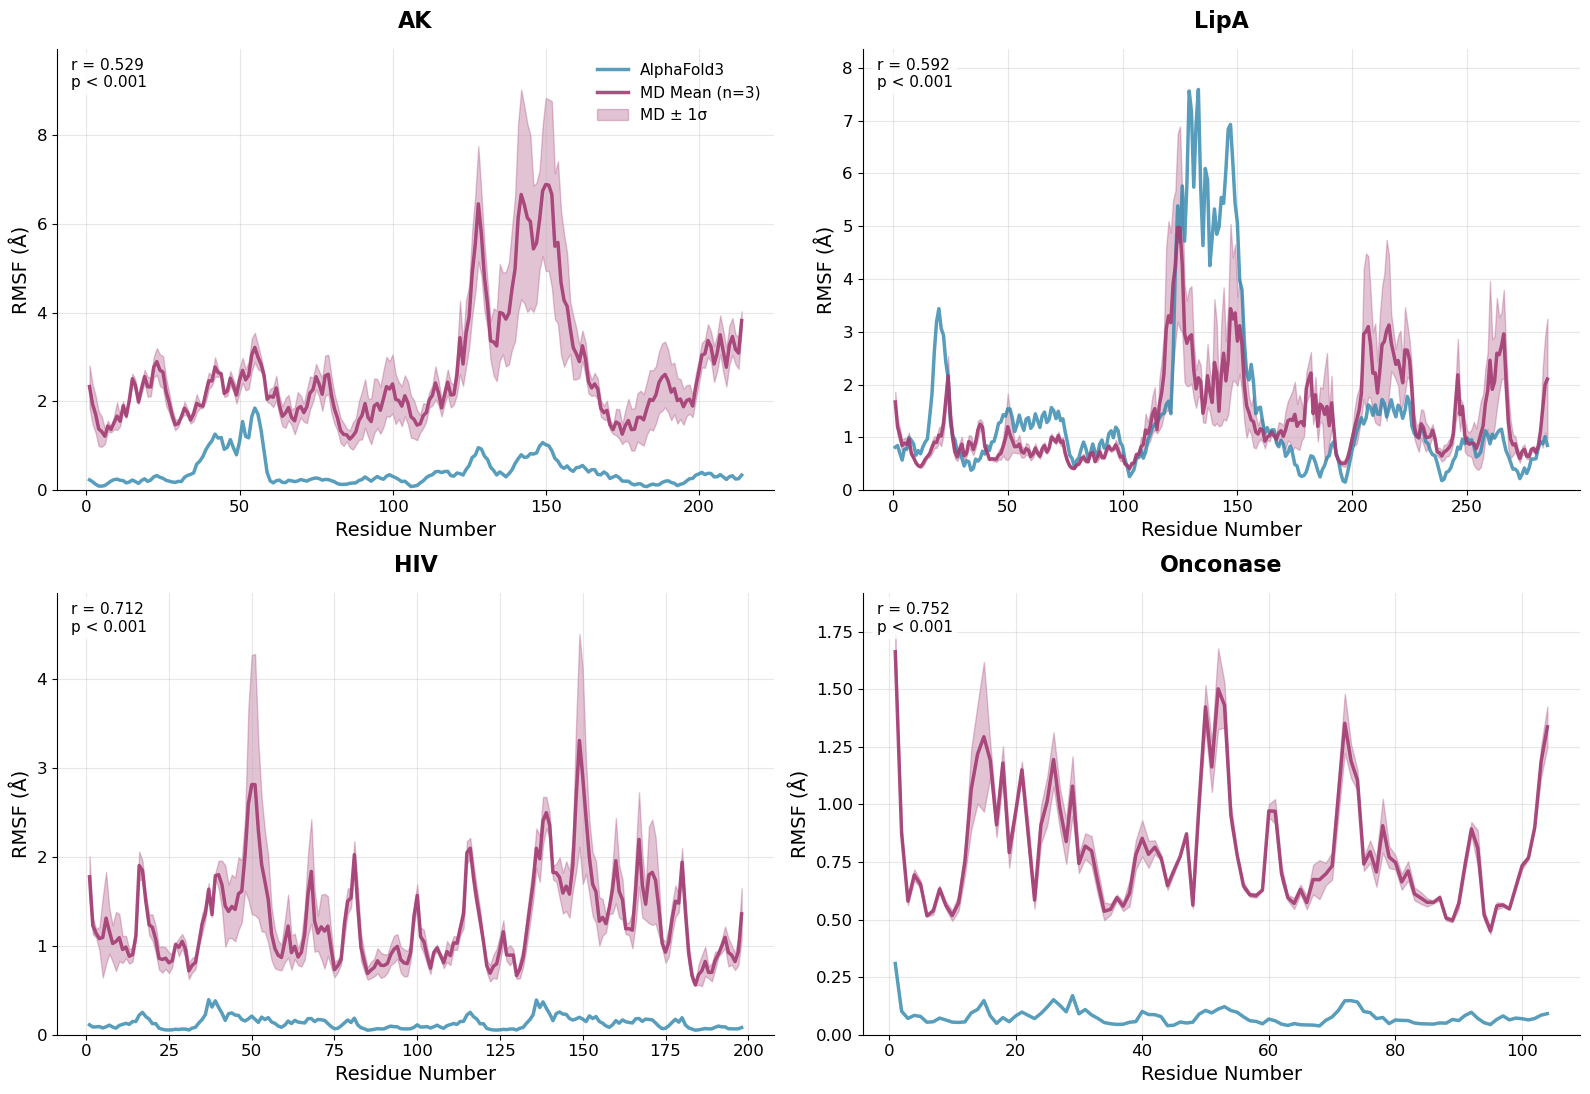

In [18]:
# Create 2x2 panel figure with RMSF plots (matching RMSD layout)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color scheme (same as RMSD plots)
af3_color = '#2E86AB'  # Blue for AF3
md_colors = ['#A23B72', '#F18F01', '#C73E1D']  # Different colors for MD runs

# Plot data for each protein target (same order as RMSD)
targets = ['AK', 'LipA', 'HIV', 'Onconase']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (target, pos) in enumerate(zip(targets, positions)):
    ax = axes[pos]
    data = rmsf_protein_data[target]
    
    # Plot AF3 data
    if data['af3'] is not None:
        residue_vals, rmsf_vals, filename = data['af3']
        ax.plot(residue_vals, rmsf_vals, color=af3_color, linewidth=2.5, 
                label='AlphaFold3', alpha=0.8)
    
    # Plot MD runs - calculate mean and std across all runs
    if len(data['md_runs']) > 0:
        # Collect all MD RMSF data
        md_rmsf_data = []
        min_length = float('inf')
        
        for residue_vals, rmsf_vals, filename in data['md_runs']:
            md_rmsf_data.append(rmsf_vals)
            min_length = min(min_length, len(rmsf_vals))
        
        if len(md_rmsf_data) > 0:
            # Truncate all arrays to the same length (minimum length)
            md_rmsf_array = np.array([rmsf[:min_length] for rmsf in md_rmsf_data])
            residue_numbers = np.arange(1, min_length + 1)
            
            # Calculate mean and standard deviation across MD runs
            md_mean = np.mean(md_rmsf_array, axis=0)
            md_std = np.std(md_rmsf_array, axis=0)
            
            # Plot mean as solid line
            md_color = '#A23B72'  # Use first MD color for consistency
            ax.plot(residue_numbers, md_mean, color=md_color, linewidth=2.5, 
                    label=f'MD Mean (n={len(md_rmsf_data)})', alpha=0.9)
            
            # Plot standard deviation as confidence band
            ax.fill_between(residue_numbers, md_mean - md_std, md_mean + md_std, 
                           color=md_color, alpha=0.3, label='MD ± 1σ')
            
            # Calculate Pearson correlation if both AF3 and MD data are available
            if data['af3'] is not None:
                af3_residue_vals, af3_rmsf_vals, af3_filename = data['af3']
                
                # Align data lengths for correlation calculation
                min_corr_length = min(len(af3_rmsf_vals), min_length)
                af3_aligned = af3_rmsf_vals[:min_corr_length]
                md_aligned = md_mean[:min_corr_length]
                
                # Calculate Pearson correlation
                from scipy.stats import pearsonr
                r_value, p_value = pearsonr(af3_aligned, md_aligned)
                
                # Add correlation info as text box without frame
                p_text = 'p < 0.001' if p_value < 0.001 else f'p = {p_value:.3f}'
                textstr = f'r = {r_value:.3f}\n{p_text}'
                props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none')
                ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
                        verticalalignment='top', bbox=props)
    
    # Customize subplot (matching RMSD style)
    ax.set_title(f'{target}', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Residue Number', fontsize=14)
    ax.set_ylabel('RMSF (Å)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Show legend only on top-left plot (AK), without frame
    if pos == (0, 0):  # Top-left position
        ax.legend(fontsize=11, frameon=False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Set axis limits and ticks
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add some padding to y-axis
    if len(ax.get_lines()) > 0:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(0, y_max + 0.05 * y_max)  # Start from 0 for RMSF

# All RMSF subplots now filled with data - no empty subplot handling needed

# Adjust layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./rmsf_analysis.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')



plt.show()

In [36]:
a=rmsf_protein_data['AK']['md_runs'][0][1]+rmsf_protein_data['AK']['md_runs'][1][1]+rmsf_protein_data['AK']['md_runs'][2][1]
b=rmsf_protein_data['AK']['af3'][1]

pearsonr(a, b)

PearsonRResult(statistic=np.float64(0.5285882318146564), pvalue=np.float64(8.419666538987949e-17))